In [ ]:
# CELL 1: Imports and Data Loading
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transformations (Convert to Tensor & Normalize)
# Fashion-MNIST mean=0.2860, std=0.3530
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to range [-1, 1]
])

# Download and load datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Class names mapping
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Data loaded successfully.")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Using device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 343kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.32MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.0MB/s]

Data loaded successfully.
Training samples: 60000
Test samples: 10000


In [ ]:
# CELL 2: Model Definition (nn.Module)
class StyleSortClassifier(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[256, 128], num_classes=10, dropout_rate=0.0):
        super(StyleSortClassifier, self).__init__()

        layers = []
        in_dim = input_size

        for h_dim in hidden_layers:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            in_dim = h_dim

        # Output layer
        layers.append(nn.Linear(in_dim, num_classes))

        # Register layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten image: (Batch_Size, 1, 28, 28) -> (Batch_Size, 784)
        x = x.view(x.shape[0], -1)
        logits = self.network(x)
        return logits

print("Model architecture defined.")

Model architecture defined.


In [ ]:
# CELL 3: Training & Evaluation Functions
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_accuracies = []

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train() # Set to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # 1. Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 2. Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on test set
        model.eval() # Set to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

--- Experiment 1: Baseline (1 Hidden Layer, 128 units) ---
Starting training for 10 epochs...
Epoch [1/10], Loss: 0.4999, Test Accuracy: 84.81%
Epoch [2/10], Loss: 0.3772, Test Accuracy: 85.36%
Epoch [3/10], Loss: 0.3429, Test Accuracy: 85.79%
Epoch [4/10], Loss: 0.3178, Test Accuracy: 87.04%
Epoch [5/10], Loss: 0.2981, Test Accuracy: 87.34%
Epoch [6/10], Loss: 0.2854, Test Accuracy: 86.95%
Epoch [7/10], Loss: 0.2710, Test Accuracy: 87.58%
Epoch [8/10], Loss: 0.2587, Test Accuracy: 87.54%
Epoch [9/10], Loss: 0.2486, Test Accuracy: 88.18%
Epoch [10/10], Loss: 0.2387, Test Accuracy: 87.54%

--- Experiment 2: Deeper (2 Hidden Layers, 256->128 units) ---
Starting training for 10 epochs...
Epoch [1/10], Loss: 0.4927, Test Accuracy: 85.15%
Epoch [2/10], Loss: 0.3650, Test Accuracy: 85.86%
Epoch [3/10], Loss: 0.3280, Test Accuracy: 87.53%
Epoch [4/10], Loss: 0.3050, Test Accuracy: 87.23%
Epoch [5/10], Loss: 0.2875, Test Accuracy: 86.40%
Epoch [6/10], Loss: 0.2683, Test Accuracy: 86.55%
Epoch 

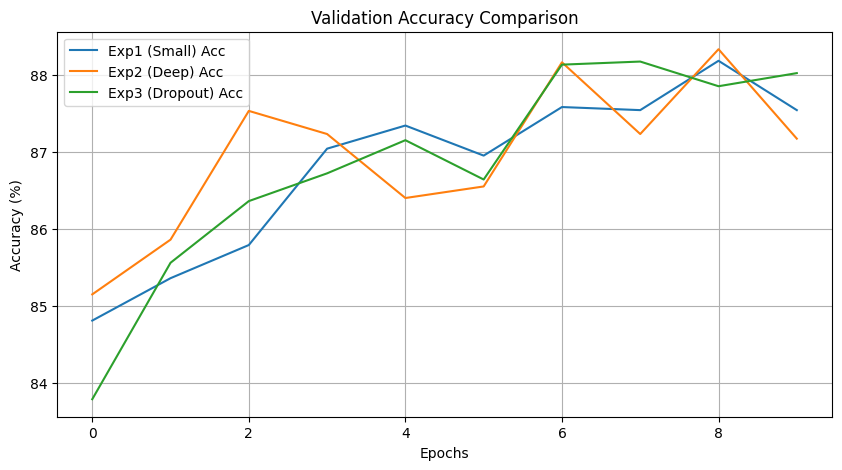

In [ ]:
# CELL 4: Running Experiments
experiments = {}

# Experiment 1: Baseline (Small Model)
print("--- Experiment 1: Baseline (1 Hidden Layer, 128 units) ---")
model_1 = StyleSortClassifier(hidden_layers=[128]).to(device)
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
metrics_1 = train_model(model_1, train_loader, test_loader, criterion, optimizer_1, num_epochs=10)
experiments['Exp1 (Small)'] = (model_1, metrics_1)

# Experiment 2: Deeper Model (2 Hidden Layers)
print("\n--- Experiment 2: Deeper (2 Hidden Layers, 256->128 units) ---")
model_2 = StyleSortClassifier(hidden_layers=[256, 128]).to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
metrics_2 = train_model(model_2, train_loader, test_loader, criterion, optimizer_2, num_epochs=10)
experiments['Exp2 (Deep)'] = (model_2, metrics_2)

# Experiment 3: Regularized (Dropout)
print("\n--- Experiment 3: Regularized (Dropout 0.2) ---")
model_3 = StyleSortClassifier(hidden_layers=[256, 128], dropout_rate=0.2).to(device)
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)
metrics_3 = train_model(model_3, train_loader, test_loader, criterion, optimizer_3, num_epochs=10)
experiments['Exp3 (Dropout)'] = (model_3, metrics_3)

# Plotting Training Curves
plt.figure(figsize=(10, 5))
for name, (_, (losses, accs)) in experiments.items():
    plt.plot(accs, label=f"{name} Acc")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

Performing detailed analysis on best model: Exp3 (Dropout)


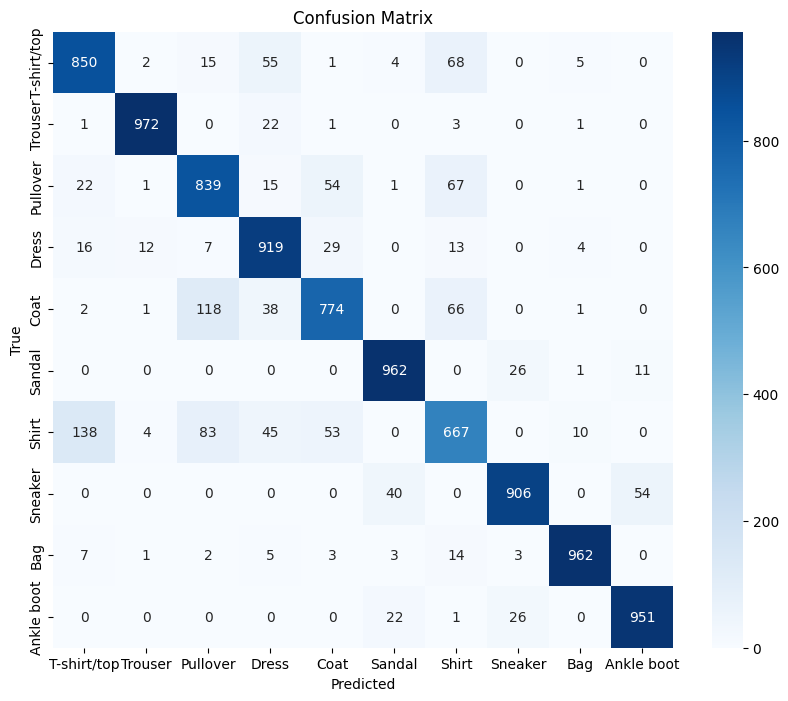

Total Misclassification Cost (Weighted): 2326.0
Standard Accuracy: 88.02%


In [ ]:
# CELL 5: Detailed Analysis of Best Model

# Select best model based on final accuracy
best_exp_name = max(experiments, key=lambda k: experiments[k][1][1][-1])
best_model = experiments[best_exp_name][0]
print(f"Performing detailed analysis on best model: {best_exp_name}")

# Get all predictions
all_preds = []
all_labels = []
all_probs = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 1. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 2. Cost-Weighted Accuracy Analysis
# Defining costs based on the prompt table [Source 83]
# Weights: Low=1, Medium=3, High=5
cost_matrix = np.zeros((10, 10))

# Specific penalties from prompt
# Bag(8) -> Sneaker(7): Low (1)
cost_matrix[8, 7] = 1
# Shirt(6) -> T-shirt(0): High (5)
cost_matrix[6, 0] = 5
# Coat(4) -> Pullover(2): High (5)
cost_matrix[4, 2] = 5
# Sandal(5) -> Sneaker(7): Medium (3)
cost_matrix[5, 7] = 3
# Ankle boot(9) -> Sneaker(7): Medium (3)
cost_matrix[9, 7] = 3

total_cost = 0
normal_errors = 0

for i in range(len(all_labels)):
    true_l = all_labels[i]
    pred_l = all_preds[i]

    if true_l != pred_l:
        # If it's a specific costly error, add that cost
        if cost_matrix[true_l, pred_l] > 0:
            total_cost += cost_matrix[true_l, pred_l]
        else:
            # Default cost for other errors (assume Low=1)
            total_cost += 1
            normal_errors += 1

print(f"Total Misclassification Cost (Weighted): {total_cost}")
print(f"Standard Accuracy: {100 * np.mean(np.array(all_labels) == np.array(all_preds)):.2f}%")

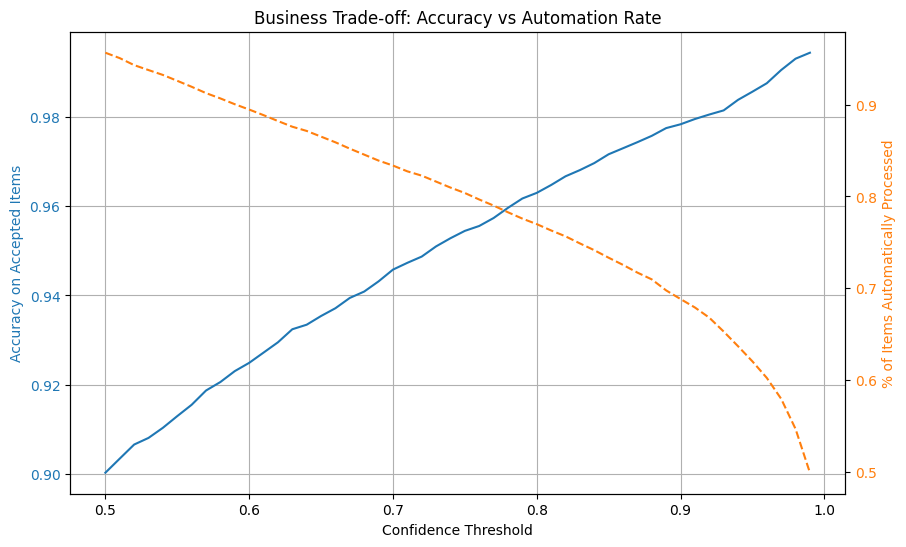

At 80% Confidence Threshold:
- Accuracy: 96.30%
- Items sent to human review: 23.01%


In [ ]:
# CELL 6: Confidence Threshold Analysis
thresholds = np.linspace(0.5, 0.99, 50)
accuracies = []
retained_ratios = []

max_probs = np.max(np.array(all_probs), axis=1)
preds_np = np.array(all_preds)
labels_np = np.array(all_labels)

for t in thresholds:
    # Indices where confidence > threshold
    idxs = max_probs > t

    if np.sum(idxs) > 0:
        acc = np.mean(preds_np[idxs] == labels_np[idxs])
        retained = np.mean(idxs)
    else:
        acc = 0
        retained = 0

    accuracies.append(acc)
    retained_ratios.append(retained)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Confidence Threshold')
ax1.set_ylabel('Accuracy on Accepted Items', color='tab:blue')
ax1.plot(thresholds, accuracies, color='tab:blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('% of Items Automatically Processed', color='tab:orange')
ax2.plot(thresholds, retained_ratios, color='tab:orange', linestyle='--', label='Processing Rate')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Business Trade-off: Accuracy vs Automation Rate')
plt.show()

# Recommendation at 80% confidence
idx_80 = np.searchsorted(thresholds, 0.80)
print(f"At 80% Confidence Threshold:")
print(f"- Accuracy: {accuracies[idx_80]*100:.2f}%")
print(f"- Items sent to human review: {(1-retained_ratios[idx_80])*100:.2f}%")

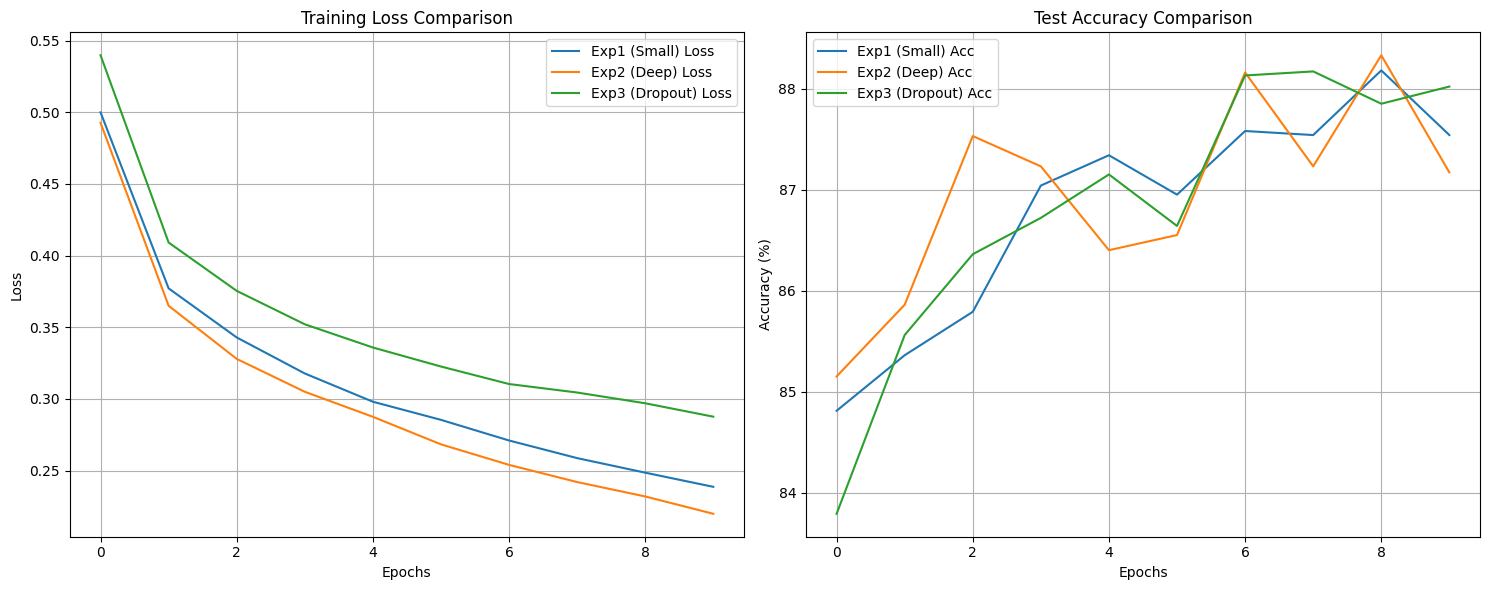

In [12]:
# CELL 7:Plotting Training Curves: Loss and Accuracy

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Training Losses
ax1.set_title("Training Loss Comparison")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
for name, (_, (losses, _)) in experiments.items():
    ax1.plot(losses, label=f"{name} Loss")
ax1.legend()
ax1.grid(True)

# Plot Test Accuracies
ax2.set_title("Test Accuracy Comparison")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
for name, (_, (_, accs)) in experiments.items():
    ax2.plot(accs, label=f"{name} Acc")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

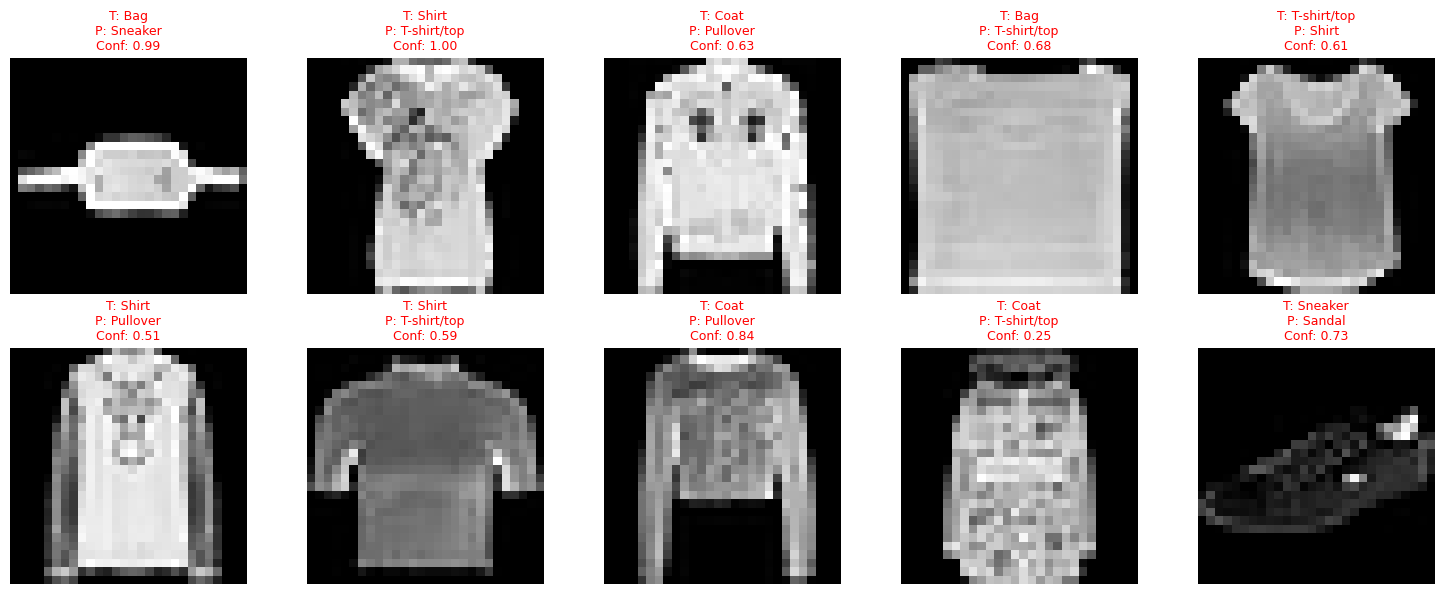

In [ ]:
# CELL 8: Misclassification Visualization
misclassified_idxs = np.where(preds_np != labels_np)[0]

# Select 10 random misclassifications
sample_idxs = np.random.choice(misclassified_idxs, 10, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(sample_idxs):
    plt.subplot(2, 5, i+1)
    # Undo normalization for display: x * 0.5 + 0.5
    img = test_dataset[idx][0].permute(1, 2, 0) * 0.5 + 0.5
    plt.imshow(img, cmap='gray')

    true_name = class_names[labels_np[idx]]
    pred_name = class_names[preds_np[idx]]
    conf = max_probs[idx]

    plt.title(f"T: {true_name}\nP: {pred_name}\nConf: {conf:.2f}", color='red', fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()